In [1]:
from pprint import pprint as pp
from typing import Dict, List, Tuple

import random
import csv
import time
import datetime

import networkx as nx

from itertools import count
from heapq import heappush, heappop

In [2]:
def printProgressBar (iteration, total, prefix = 'Progress: ', suffix = 'Completed', decimals = 1, length = 50, fill = '█'):

    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    styling = f'{prefix} |{fill}| {percent}%% {suffix}'
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s' % styling.replace(fill, bar), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

# Sample Usage
import shutil, time

# A List of Items
items = list(range(0, 57))
l = len(items)

# Initial call to print 0% progress
printProgressBar(0, l)
for i, item in enumerate(items):
    # Do stuff...
    time.sleep(0.03)
    # Update Progress Bar
    printProgressBar(i + 1, l)

Progress:  |██████████████████████████████████████████████████| 100.0%% Completed


In [3]:
def sample_from_dict(d, sample=10):
    keys = random.sample(list(d), sample)
    values = [d[k] for k in keys]
    return dict(zip(keys, values))

# Building Knowledge Graph

## Extract Data from CSV

In [4]:
def get_csv_data(filepath, handle_row_func, row_limit=None):
    data = dict()
    with open(filepath) as file:
        next(file)
        rows = csv.reader(file, delimiter=",")
        cnt = 0
        for row in rows:
            handle_row_func(data, row)
            
            cnt += 1
            if row_limit != None and cnt == row_limit:
                break
            
    return data

In [5]:
def handle_csv_kanji_func(data, row):
    kanji,*meanings = row
    if len(meanings) >= 2:
        meanings = ",".join(meanings)
    else:
        meanings = meanings[0]
    meanings = meanings.split(":")
    meanings = meanings[0]
    data[kanji] = meanings

In [6]:
data_kanji = get_csv_data(
    "dataset/s5_kanjis_output.csv", 
    handle_csv_kanji_func, 
    row_limit=4900,
)
print("len(data_kanji) = ", len(data_kanji))
# pp(sample_from_dict(data_kanji))

len(data_kanji) =  4393


In [7]:
radical_no_meaning = {"｜", "丶", "丿", "乙", "亅", "冖"}

In [8]:
def handle_csv_radical_func(data, row):
    radical,meaning,_ = row  
    if radical not in radical_no_meaning:
        data[radical] = meaning

In [9]:
data_radical = get_csv_data(
    "dataset/s7_nodes_radical_meaning.csv", 
    handle_csv_radical_func
)
print("len(data_radical) = ", len(data_radical))
pp(sample_from_dict(data_radical))

len(data_radical) =  249
{'.阝': 'right village',
 '九': 'nine',
 '入': 'enter',
 '凵': 'open box',
 '工': 'craft',
 '巴': 'comma-design',
 '干': 'dry',
 '彡': 'short hair',
 '石': 'stone',
 '首': 'neck'}


In [10]:
def handle_csv_edges_func(data, row):
    kanji,radical_list = row
    if kanji in data_kanji:
        data[kanji] = radical_list.split(':')
        data[kanji] = list(set(data[kanji]) - radical_no_meaning)

In [11]:
data_edges = get_csv_data("dataset/s7_edges_kanji_radical.csv", handle_csv_edges_func)
print("len(data_edges) = ", len(data_edges))
# pp(sample_from_dict(data_edges))

len(data_edges) =  4393


## Data Structure

### Node Manager

In [12]:
get_key = lambda symbol, dtype : f"{symbol}-{dtype}"

In [13]:
node_kanji = {
    get_key(symbol, 'kanji'): {
        'symbol' : symbol,
        'meaning': meaning,
        'visual' : f"{symbol}\n{meaning}",
        'idx'    : idx,
        'color'  : 'red',
    } for idx, (symbol, meaning) in enumerate(list(data_kanji.items()))}

In [14]:
node_radical = {
    get_key(symbol, 'radical'): {
        'symbol' : symbol,
        'meaning': meaning,
        'visual' : f"{symbol}\n{meaning}",
        'idx'    : idx,
        'color'  : 'yellow',
    } for idx, (symbol, meaning) in enumerate(list(data_radical.items()))}

In [15]:
full_node = {**node_radical, **node_kanji}
# pp(sample_from_dict(full_node))

### Edge Manager

In [16]:
def get_graph_edge(data_edges):
    edges = []
    for kanji, radicals in data_edges.items():
        for r in radicals:
            edges.append( (f"{kanji}-kanji", f"{r}-radical") )
    return edges

In [17]:
full_edges = get_graph_edge(data_edges)
# full_edges[:10]

## Kanji Graph

In [18]:
kjg_raw = nx.Graph()

kjg_raw.add_nodes_from(full_node.items())
kjg_raw.add_edges_from(full_edges)

In [19]:
# PREPROCESSING: ENFORCE CONNECTED GRAPH
# https://networkx.org/documentation/stable/reference/algorithms/isolates.html
# EDA + Preprocessing: Removing Isolated Nodes

def enforce_connected_graph(G):
    n_conn = nx.number_connected_components(G)
    n_iso  = nx.number_of_isolates(G)
    print('number of connected components: ', nx.number_connected_components(G))
    print('number of isolated: ', n_iso)

    if n_iso > 1:
        G.remove_nodes_from(list(nx.isolates(G)))
        
    n_conn = nx.number_connected_components(G)
    if n_conn != 1:
        raise ValueError(f"Number of connected components must be 1, not {n_conn}")
    else:
        print("Graph is already connected")
    return G

In [20]:
kjg = enforce_connected_graph(kjg_raw)

number of connected components:  31
number of isolated:  30
Graph is already connected


In [21]:
print(nx.info(kjg))

Graph with 4612 nodes and 15297 edges


### Graph Viz Lib

In [22]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm

# Reference: https://albertauyeung.github.io/2020/03/15/matplotlib-cjk-fonts.html
[f for f in fm.fontManager.ttflist if 'CJK JP' in f.name]

[<Font 'Noto Serif CJK JP' (NotoSerifCJK-Regular.ttc) normal normal 400 normal>,
 <Font 'Noto Sans CJK JP' (NotoSansCJK-Bold.ttc) normal normal 700 normal>,
 <Font 'Noto Serif CJK JP' (NotoSerifCJK-Bold.ttc) normal normal 700 normal>,
 <Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal 400 normal>]

In [23]:
def visualize_graph(
    Graph: nx.Graph, 
    figsize: tuple=(7,7), 
    color_map: List[str]=None, 
    node_size: int=3000, 
    label_attr: str='visual' # valid value: 'idx', 'visual' 
) -> None:
    
    if color_map == None:
        color_map = [Graph.nodes[n]["color"] for n in Graph] 
    else:
        color_map = color_map
    
    plt.figure(1,figsize=figsize)    
    
    labels = nx.get_node_attributes(Graph, label_attr)
    
    nx.draw_kamada_kawai(Graph, 
                         node_color=color_map, 
                         with_labels=True,
                         labels=labels,
                         node_size=node_size, 
                         font_size=20,
                         font_family="Noto Serif CJK JP")
    plt.show()

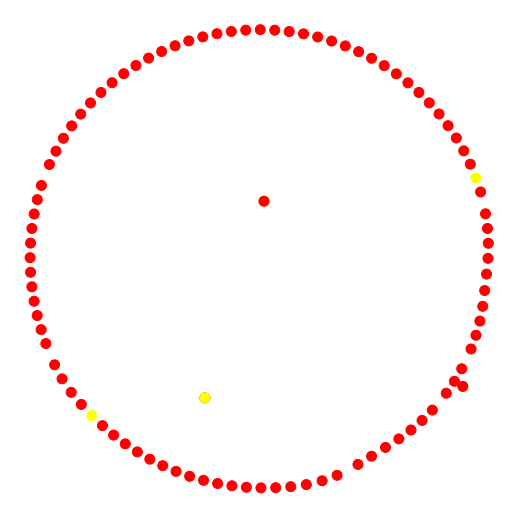

In [24]:
visualize_graph(
    Graph       = kjg.subgraph(random.sample(kjg.nodes, 100)),
    node_size   = 100,
    label_attr  = '', #:  idx or visual
)

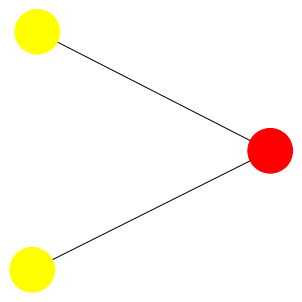

In [25]:
def get_sg_kanji_with(kjg) -> nx.Graph:
    sg = nx.Graph()
    p = '嘩-kanji'
    radicals = [n for n in kjg.neighbors(p)]
    sg.add_nodes_from([(p, kjg.nodes[p])] + [(r, kjg.nodes[r]) for r in radicals])
    sg.add_edges_from([(p, rp) for rp in radicals])
    return sg

visualize_graph(
    Graph       = get_sg_kanji_with(kjg),
    node_size   = 2000,
    figsize     = (4,4),
    label_attr  = None
)

### Graph Function

In [26]:
def generate_graph(G: nx.Graph, nodes: List) -> nx.Graph:
    R = nx.Graph()
    R.add_nodes_from([(n, G.nodes[n]) for n in nodes])
    R.add_edges_from(nx.utils.pairwise(nodes))
    return R

In [27]:
def get_node_color_result(g, kinputs, koutputs):
    color_map = []
    for n in g:
        if n in kinputs:
            color_map.append("green") # input
        elif n in koutputs:
            color_map.append("blue")  # output
        else:
            color_map.append(g.nodes[n]["color"])
    return color_map

In [28]:
def visualize_result(g_res, kinputs, koutputs, figsize=(5,5), label_attr='visual'):
    visualize_graph(
        Graph=g_res, 
        color_map=get_node_color_result(g_res, kinputs, koutputs), 
        figsize=figsize,
        label_attr=label_attr,
    )

## Graph Alternatives

### Graph Internet

In [29]:
g_ias = nx.random_internet_as_graph(300, 10)
nx.set_node_attributes(g_ias, {n: {"visual": n, "color": "yellow"} for n in g_ias.nodes})

# visualize_graph(
#     Graph       = g_ias,
#     node_size   = 500,
#     figsize     = (4,4),
#     with_labels = True,
# )

In [30]:
# kin = 49  # say
# kout = 41 # lie 

# result_shortest_path = nx.shortest_path(G=g_ias, source=kin, target=kout)
# result = generate_graph(g_ias, result_shortest_path)

# visualize_result(
#     g_res=result, 
#     kinputs=[kin],
#     koutputs=[kout]
# )

## Graph List

In [31]:
subgraph_edges = [(e[0][0], [1][0]) for e in random.sample(full_edges, 2000)]
sample_graph   = nx.Graph(subgraph_edges)
sample_graph   = enforce_connected_graph(sample_graph)

number of connected components:  1
number of isolated:  0
Graph is already connected


In [32]:
gg = {
        'kjg': kjg, 
        'ias': g_ias
     }

print('number of isolated clean: ', nx.number_of_isolates(gg['kjg']))
print('number of connected clean: ', nx.number_connected_components(gg['kjg']))

number of isolated clean:  0
number of connected clean:  1


# Querying Knowledge Graph

## Data Structure

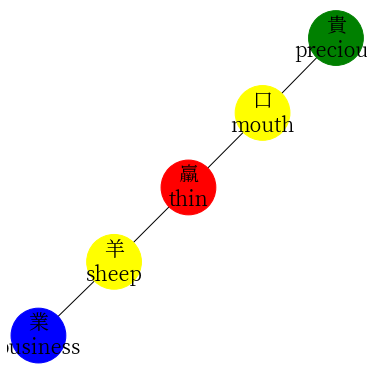

In [33]:
kin = '貴-kanji'  # precious
kout = '業-kanji' # business 

result_sp = nx.shortest_path(G=kjg, source=kin, target=kout)
result = generate_graph(kjg, result_sp)

visualize_result(
    g_res=result, 
    kinputs=[kin],
    koutputs=[kout],
    label_attr='visual'
)

## Algorithm

### Brute Force Algorithm

In [34]:
def find_path_bf(G: nx.Graph, MOrig: List, MDest: List) -> nx.Graph:
    
    result = []
    
    for kin in MOrig: # O(|MOrig|)
        for kout in MDest: # O(|MDest|)
            sp_raw = nx.dijkstra_path(G, source=kin, target=kout)
            # O( (|GV|+|GE|) log |GV|)
            
            sp_graph = generate_graph(G, sp_raw)
            
            result.append(sp_graph)
    
    
    return nx.compose_all(result)        

In [35]:
MOrig = ['逢-kanji','嘩-kanji']
MDest = ['颶-kanji','鴪-kanji','賠-kanji','蛤-kanji']

In [36]:
MOrig = ['姻-kanji','寥-kanji'] # matrimony, noisy
MDest = ['姑-kanji','嘩-kanji','蛤-kanji'] # mother in law, lonely

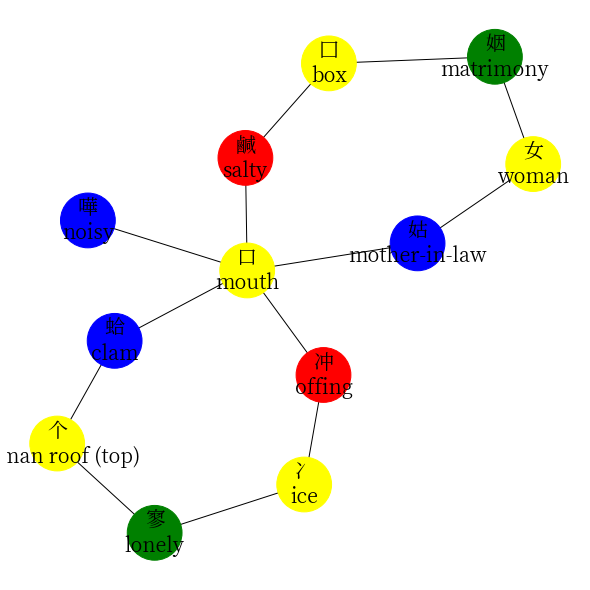

In [37]:
result = find_path_bf(gg['kjg'], MOrig, MDest)
visualize_result(
    g_res=result, 
    kinputs=MOrig,
    koutputs=MDest,
    figsize=(8,8),
    label_attr='visual'
)

### Astar Algorithm

#### Heuristic

In [38]:
g_curr = gg['kjg']

In [39]:
def common_neighbor_helper(g_curr, u,v):
    nu = g_curr[u].keys() # O(1)
    nv = g_curr[v].keys() # O(1)
    return len(nu & nv) # O(min(|nu|,|nv|))

In [40]:
def common_neighbor(u, v):
    return common_neighbor_helper(g_curr,u,v)

In [41]:
def jaccard_similarity(u, v):
    G = g_curr
    union_size = len(set(G[u]) | set(G[v])) # union neighbor
    if union_size == 0:
        return 0
    return common_neighbor_helper(G,u,v) / union_size

#### Main A* 

In [42]:
def find_path_astar(G: nx.Graph, MOrig: List, MDest: List, heuristic_func) -> nx.Graph:
    
    result = []
    
    for kin in MOrig: # O(|MOrig|)
        for kout in MDest: # (|MDest|)
            sp_raw = nx.astar_path(G, source=kin, target=kout, heuristic=heuristic_func)
            # O( (|GV|+|GE|) log |GV|)
            
            sp_graph = generate_graph(G, sp_raw)
            
            result.append(sp_graph)
    
    
    return nx.compose_all(result)        

### Steiner Tree

In [43]:
def _dijkstra_multisource(
    G, sources, weight, pred=None, paths=None, cutoff=None, target=None
):
    G_succ = G._succ if G.is_directed() else G._adj

    push = heappush
    pop = heappop
    dist = {}  # dictionary of final distances
    seen = {}
    # fringe is heapq with 3-tuples (distance,c,node)
    # use the count c to avoid comparing nodes (may not be able to)
    c = count()
    fringe = []
    for source in sources:
        if source not in G:
            raise nx.NodeNotFound(f"Source {source} not in G")
        seen[source] = 0
        push(fringe, (0, next(c), source))
    while fringe:
        (d, _, v) = pop(fringe)
        if v in dist:
            continue  # already searched this node.
        dist[v] = d
        if v == target:
            break
        for u, e in G_succ[v].items():
            cost = weight(v, u, e)
            if cost is None:
                continue
            vu_dist = dist[v] + cost
            if cutoff is not None:
                if vu_dist > cutoff:
                    continue
            if u in dist:
                u_dist = dist[u]
                if vu_dist < u_dist:
                    raise ValueError("Contradictory paths found:", "negative weights?")
                elif pred is not None and vu_dist == u_dist:
                    pred[u].append(v)
            elif u not in seen or vu_dist < seen[u]:
                seen[u] = vu_dist
                push(fringe, (vu_dist, next(c), u))
                if paths is not None:
                    paths[u] = paths[v] + [u]
                if pred is not None:
                    pred[u] = [v]
            elif vu_dist == seen[u]:
                if pred is not None:
                    pred[u].append(v)
    return dist

In [44]:
def multi_source_dijkstra(G, sources, target=None, cutoff=None, weight="weight"):
    if target in sources:
        return (0, [target])
    weight = lambda u, v, data: data.get(weight, 1)
    paths = {source: [source] for source in sources}  # dictionary of paths
    dist = _dijkstra_multisource(G, sources, weight, paths=paths)
    if target is None:
        return (dist, paths)
    try:
        return (dist[target], paths[target])
    except KeyError as e:
        raise nx.NetworkXNoPath(f"No path to {target}.") from e

In [45]:
def my_all_pairs_dijkstra(G):
    i = 0
    for n in G:
        i += 1
        print('\r%s' % i, end = '\r')
        dist, path = multi_source_dijkstra(G, {n})
        yield (n, (dist, path))

In [46]:
def metric_closure(G, weight="weight"):
    M = nx.Graph()

    Gnodes = set(G)

    all_paths_iter = my_all_pairs_dijkstra(G)
    for u, (distance, path) in all_paths_iter:
        Gnodes.remove(u)
        for v in Gnodes:
            M.add_edge(u, v, distance=distance[v], path=path[v])

    return M

In [47]:
mcg = metric_closure(g_curr, weight='weight')

In [48]:
from itertools import chain
from networkx.utils import pairwise


def my_steiner_tree(G, terminal_nodes, weight="weight", is_mcg=True):
    global mcg
    
    # H is the subgraph induced by terminal_nodes in the metric closure M of G. 
    if is_mcg:
        M = mcg
    else:
        M = metric_closure(G, weight=weight) # O(|GV|^2)
    H = M.subgraph(terminal_nodes) # O(|GV|^2) * O(|MOrig| + |MDest|)
    
    # Use the 'distance' attribute of each edge provided by M.
    mst_edges = nx.minimum_spanning_edges(H, weight="distance", data=True) # O (|GE| log GV)
    
    
    # Create an iterator over each edge in each shortest path; repeats are okay
    edges = chain.from_iterable(pairwise(d["path"]) for u, v, d in mst_edges)
    

    T = G.edge_subgraph(edges)
    
    return T

In [49]:
def find_path_steiner(G: nx.Graph, MOrig: List, MDest: List, is_mcg: bool) -> nx.Graph:
    
    return my_steiner_tree(G, MOrig + MDest, is_mcg=is_mcg)

In [50]:
# result = find_path_steiner(gg['ias'], MOrig, MDest)
# visualize_result(
#     g_res=result, 
#     kinputs=MOrig,
#     koutputs=MDest,
#     figsize=(8,8)
# )

# Experiment

## Test Case

In [51]:
from kanji_lists import JLPT, KYOIKU
# https://github.com/ffe4/kanji-lists

In [52]:
test_cases_raw = {
    'N5 to N4': {
        'MOrig': list(JLPT.N5)[:3],
        'MDest': list(JLPT.N4)[:7],
    },
    'G1 to G2': {
        'MOrig': list(KYOIKU.GRADE1)[:13],
        'MDest': list(KYOIKU.GRADE2)[:17],
    },
    'G2 to G3': {
        'MOrig': list(KYOIKU.GRADE2)[:20],
        'MDest': list(KYOIKU.GRADE3)[:30],
    },
#     'N4 to N3': {
#         'MOrig': list(JLPT.N4)[:30],
#         'MDest': list(JLPT.N3)[:70],
#     },
#     'N3 to N2': {
#         'MOrig': list(JLPT.N3)[:60],
#         'MDest': list(JLPT.N2)[:140],
#     },
#     'G3 to G4': {
#         'MOrig': list(KYOIKU.GRADE3)[:160],
#         'MDest': list(KYOIKU.GRADE4)[:240],
#     },
#     'G4 to G5': {
#         'MOrig': list(KYOIKU.GRADE4)[:240],
#         'MDest': list(KYOIKU.GRADE5)[:360],
#     },
#     'N2 to N1': {
#         'MOrig': list(JLPT.N2)[:400],
#         'MDest': list(JLPT.N1)[:600],
#     },
#     'G5 to G6': {
#         'MOrig': list(KYOIKU.GRADE5)[:500],
#         'MDest': list(KYOIKU.GRADE6)[:700],
#     },
    
    # gg['ias']
#     'tc_ias_1': {
#         'MOrig': [1,2,3],
#         'MDest': [91,92,93]
#     },
#     'tc_ias_2': {
#         'MOrig': [i*11 for i in range(33)],
#         'MDest': [i*10 for i in range(66)]
#     },
#     'tc_ias_3': {
#         'MOrig': [i*12 for i in range(100) if i*12 < 3000],
#         'MDest': [i*13 for i in range(200) if i*13 < 3000]
#     },
#     'tc_ias_4': {
#         'MOrig': [i*13 for i in range(200) if i*13 < 3000],
#         'MDest': [i*14 for i in range(300) if i*14 < 3000]
#     },
#     'tc_ias_5': {
#         'MOrig': [i*5 for i in range(400) if i*5 < 3000],
#         'MDest': [i*7 for i in range(500) if i*7 < 3000]
#     },
#     'tc_ias_6': {
#         'MOrig': [i*7 for i in range(600) if i*7 < 3000],
#         'MDest': [i*3 for i in range(700) if i*3 < 3000]
#     },
}
# test_cases_raw

In [53]:
def tc_filter_in_graph(G, kanji_list):
    
    tc_filtered = []
    for k in kanji_list:

        tk = get_key(k, 'kanji')
        
        if tk in G:
            tc_filtered.append(tk)
            continue
        
        tr = get_key(k, 'radical')
        if tr in G:
            tc_filtered.append(tr)
            continue
            
    return tc_filtered

In [54]:
def filter_test_cases_raw(G, test_cases_raw):
    test_cases_clean = {}
    for tc_name, tc in test_cases_raw.items():

        MOrig = tc_filter_in_graph(G, tc['MOrig'])
        MDest = tc_filter_in_graph(G, tc['MDest'])

        test_cases_clean[tc_name] = {
            'MOrig': MOrig,
            'MDest': MDest,
        }

    return test_cases_clean

In [55]:
test_cases_clean = filter_test_cases_raw(g_curr, test_cases_raw)

In [56]:
def find_path(G: nx.Graph, MOrig: List, MDest: List, method='brute_force') -> nx.Graph:
    if method == 'brute_force':
        return find_path_bf(G, MOrig, MDest)
    elif method == 'steiner_tree':
        return find_path_steiner(G, MOrig, MDest, is_mcg=False)
    elif method == 'steiner_tree_precompute':
        return find_path_steiner(G, MOrig, MDest, is_mcg=True)
    elif method == 'astar_common_neighbor':
        return find_path_astar(G, MOrig, MDest, common_neighbor)
    elif method == 'astar_jaccard':
        return find_path_astar(G, MOrig, MDest, jaccard_similarity)
    elif method == 'astar_0':
        return find_path_astar(G, MOrig, MDest, lambda x, y: 0)
    else:
        raise ValueError(f"method {method} is not valid")

## Testing

In [57]:
def get_result_accuracy(G0, Gt):
    common_nodes = len(G0.nodes() & Gt.nodes())
    G0_nodes     = len(G0.nodes())
    
    return common_nodes / G0_nodes

In [58]:
def get_results_kanjigen(G: nx.Graph, test_cases_clean: dict, algo_list: List):
    results = {tc_name: dict() for tc_name in test_cases_clean}

    for tc_name, tc in test_cases_clean.items():
        
        
        MOrig = tc['MOrig']
        MDest = tc['MDest']
        
        if len(MOrig) == 0 or len(MDest) == 0:
            continue
        
        print(f"""
        ################
        len(MOrig) == {len(MOrig)}
        len(MDest) == {len(MDest)}
        ################
        """)
        
        # get time
        for algo in algo_list:
            
            print(f"algo: {algo}")
            print(f"tc: {tc_name} of {len(test_cases_clean)}")
            start  = time.time()
            graph  = find_path(G, MOrig, MDest, algo)
            end    = time.time()
            print(f"finish at {datetime.datetime.now()} after {end - start} seconds")
            print("==============")
            
            results[tc_name][algo] = {'graph': graph, 'time': (end - start)}
        
        # get used_vertices
        for algo in algo_list:
            Gt = results[tc_name][algo]['graph']
            results[tc_name][algo]["used_vertices"] = len(Gt) - len(MOrig) - len(MDest)
        
        print("----------------------")
        print(results)
        print("----------------------")
    return results

In [59]:
algo_list = ['brute_force', 'astar_0', 'astar_common_neighbor', 'astar_jaccard', 'steiner_tree', 'steiner_tree_precompute']
algo_list = ['brute_force', 'astar_0', 'astar_common_neighbor', 'astar_jaccard', 'steiner_tree_precompute']

In [60]:
results = get_results_kanjigen(g_curr, test_cases_clean, algo_list)


        ################
        len(MOrig) == 1
        len(MDest) == 6
        ################
        
algo: brute_force
tc: N5 to N4 of 3
finish at 2021-09-17 00:06:34.507268 after 0.12206888198852539 seconds
algo: astar_0
tc: N5 to N4 of 3
finish at 2021-09-17 00:06:34.641139 after 0.13332915306091309 seconds
algo: astar_common_neighbor
tc: N5 to N4 of 3
finish at 2021-09-17 00:06:34.929791 after 0.2885277271270752 seconds
algo: astar_jaccard
tc: N5 to N4 of 3
finish at 2021-09-17 00:06:35.245854 after 0.3159482479095459 seconds
algo: steiner_tree_precompute
tc: N5 to N4 of 3
finish at 2021-09-17 00:06:35.253449 after 0.007480144500732422 seconds
----------------------
{'N5 to N4': {'brute_force': {'graph': <networkx.classes.graph.Graph object at 0x7fd8c753ac40>, 'time': 0.12206888198852539, 'used_vertices': 13}, 'astar_0': {'graph': <networkx.classes.graph.Graph object at 0x7fd8c753a9a0>, 'time': 0.13332915306091309, 'used_vertices': 13}, 'astar_common_neighbor': {'graph': <net

In [61]:
pp(results)

{'G1 to G2': {'astar_0': {'graph': <networkx.classes.graph.Graph object at 0x7fd8c75d9730>,
                          'time': 2.0311672687530518,
                          'used_vertices': 84},
              'astar_common_neighbor': {'graph': <networkx.classes.graph.Graph object at 0x7fd8c74638b0>,
                                        'time': 7.8514039516448975,
                                        'used_vertices': 93},
              'astar_jaccard': {'graph': <networkx.classes.graph.Graph object at 0x7fd8c75d9a60>,
                                'time': 8.350015640258789,
                                'used_vertices': 67},
              'brute_force': {'graph': <networkx.classes.graph.Graph object at 0x7fd8c761d040>,
                              'time': 1.5985541343688965,
                              'used_vertices': 84},
              'steiner_tree_precompute': {'graph': <networkx.classes.graph.Graph object at 0x7fd8c7463610>,
                                          'ti

# Analysis

In [62]:
results

{'N5 to N4': {'brute_force': {'graph': <networkx.classes.graph.Graph at 0x7fd8c753ac40>,
   'time': 0.12206888198852539,
   'used_vertices': 13},
  'astar_0': {'graph': <networkx.classes.graph.Graph at 0x7fd8c753a9a0>,
   'time': 0.13332915306091309,
   'used_vertices': 13},
  'astar_common_neighbor': {'graph': <networkx.classes.graph.Graph at 0x7fd8c753ae20>,
   'time': 0.2885277271270752,
   'used_vertices': 13},
  'astar_jaccard': {'graph': <networkx.classes.graph.Graph at 0x7fd8c753ac70>,
   'time': 0.3159482479095459,
   'used_vertices': 16},
  'steiner_tree_precompute': {'graph': <networkx.classes.graph.Graph at 0x7fd8c753adf0>,
   'time': 0.007480144500732422,
   'used_vertices': 10}},
 'G1 to G2': {'brute_force': {'graph': <networkx.classes.graph.Graph at 0x7fd8c761d040>,
   'time': 1.5985541343688965,
   'used_vertices': 84},
  'astar_0': {'graph': <networkx.classes.graph.Graph at 0x7fd8c75d9730>,
   'time': 2.0311672687530518,
   'used_vertices': 84},
  'astar_common_neighbor

In [63]:
def get_df_results(results, algo_list):
    df_results = {algo: dict() for algo in algo_list}
    for tc_name, res in results.items():
        
        
        for algo in algo_list:
            if algo not in res:
                continue
            
            if tc_name not in df_results[algo]:
                df_results[algo][tc_name] = dict()
                
            df_results[algo][tc_name]['time']     = round(res[algo]['time'], 2)
            df_results[algo][tc_name]['uv']  = res[algo]['used_vertices']

    return df_results

In [64]:
df_results = get_df_results(results, algo_list)
df_results

{'brute_force': {'N5 to N4': {'time': 0.12, 'uv': 13},
  'G1 to G2': {'time': 1.6, 'uv': 84},
  'G2 to G3': {'time': 11.49, 'uv': 188}},
 'astar_0': {'N5 to N4': {'time': 0.13, 'uv': 13},
  'G1 to G2': {'time': 2.03, 'uv': 84},
  'G2 to G3': {'time': 6.1, 'uv': 188}},
 'astar_common_neighbor': {'N5 to N4': {'time': 0.29, 'uv': 13},
  'G1 to G2': {'time': 7.85, 'uv': 93},
  'G2 to G3': {'time': 16.33, 'uv': 192}},
 'astar_jaccard': {'N5 to N4': {'time': 0.32, 'uv': 16},
  'G1 to G2': {'time': 8.35, 'uv': 67},
  'G2 to G3': {'time': 18.71, 'uv': 132}},
 'steiner_tree_precompute': {'N5 to N4': {'time': 0.01, 'uv': 10},
  'G1 to G2': {'time': 0.02, 'uv': 18},
  'G2 to G3': {'time': 0.04, 'uv': 27}}}

In [65]:
import pandas as pd
import numpy as np

In [66]:
df = pd.DataFrame(df_results)

In [67]:
df

,brute_force,astar_0,astar_common_neighbor,astar_jaccard,steiner_tree_precompute
N5 to N4,"{'time': 0.12, 'uv': 13}","{'time': 0.13, 'uv': 13}","{'time': 0.29, 'uv': 13}","{'time': 0.32, 'uv': 16}","{'time': 0.01, 'uv': 10}"
G1 to G2,"{'time': 1.6, 'uv': 84}","{'time': 2.03, 'uv': 84}","{'time': 7.85, 'uv': 93}","{'time': 8.35, 'uv': 67}","{'time': 0.02, 'uv': 18}"
G2 to G3,"{'time': 11.49, 'uv': 188}","{'time': 6.1, 'uv': 188}","{'time': 16.33, 'uv': 192}","{'time': 18.71, 'uv': 132}","{'time': 0.04, 'uv': 27}"


# Demo

In [68]:
# What user input into application
# Demo: 1
# MOrig = ['姻','寥'] # matrimony, noisy
# MDest = ['姑','嘩','唹'] # mother in law, lonely, laugh

In [69]:
# What user input into application
# Demo: 2
MOrig = ['学','栄'] # learn, flourish
MDest = ['塾','術','宝', '輔'] # cram school, art, treasure, help

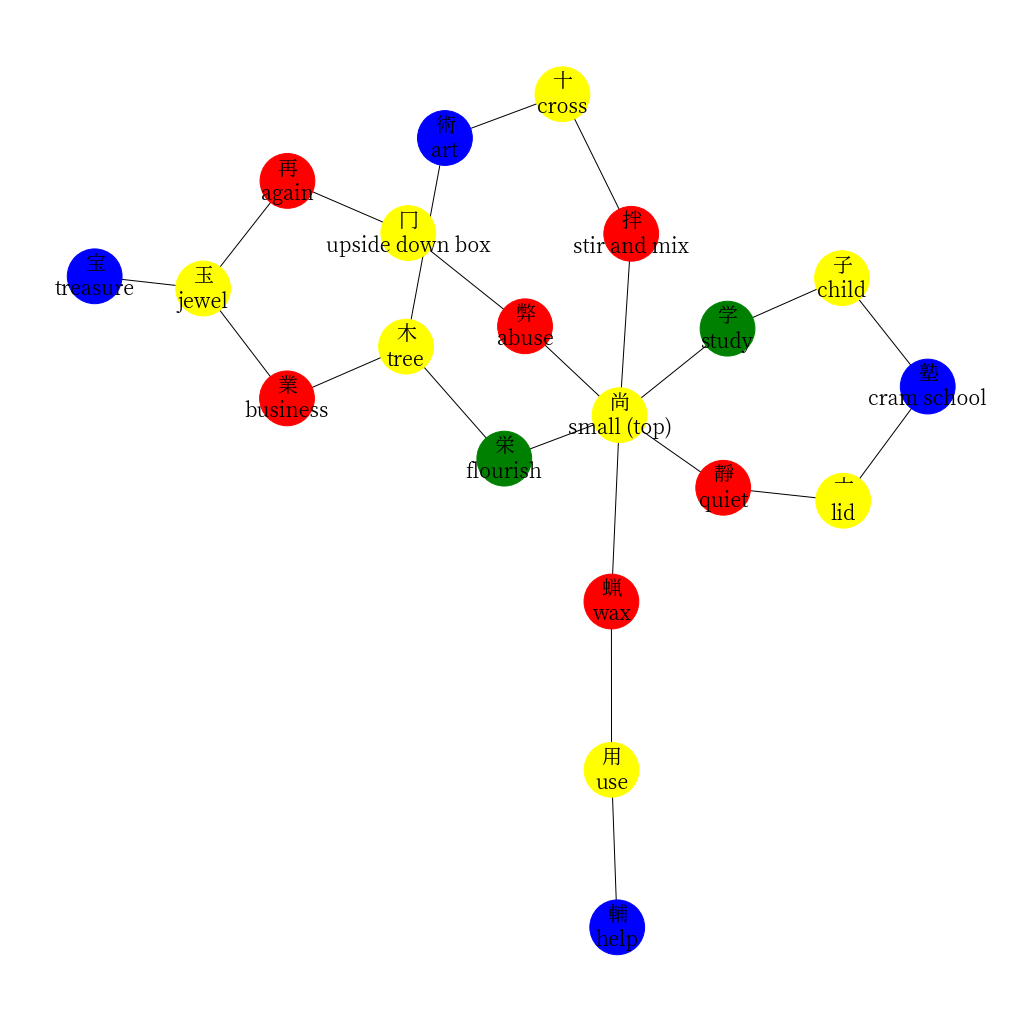

In [72]:
# Transformation: to differentiate 日-radical and 日-kanji
MOrigf = [f"{x}-kanji" for x in MOrig]
MDestf = [f"{x}-kanji" for x in MDest]


result = find_path(gg['kjg'], MOrigf, MDestf, 'brute_force')
visualize_result(
    g_res=result, 
    kinputs=MOrigf,
    koutputs=MDestf,
    figsize=(14,14),
    label_attr='visual'
)